In [0]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.version
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from random import shuffle

from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
#TF Version
tf.__version__

#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=FutureWarning)
#    import h5py

num_periods_output = 12 #to predict
num_periods_input=24 #input
l_rate = 0.0003   
MiniBatches_size=128
keep_probab=0.9            #(1-dropout_rate)
keep_prob_testval=1.0  
epochs = 500   
Number_of_TimeFeatures=23+37+18
inputs = Number_of_TimeFeatures-1 
lamda=0.4 


No_Of_weeks=1

ALL_Test_Data=[]
ALL_Test_Prediction=[]


## preprocessing

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

def preprocessing(df_,num_features):
    
    if df_.ID[0]!=7 and df_.ID[0]!=8:
        print(df_.Year.unique())
        df=df_[(df_.Year==2017) | (df_.Year==2018)]
        #.isin(years)
        #print(df.loc[df['Year'].isin([2017,2018])])
        print(df.Year.unique())
        print(df.Capacity.unique())
    else:
        df=df_[(df_.Year==2015) | (df_.Year==2016)]
        print(df.Year.unique())
        print(df.Capacity.unique())
    
    '''df_=df[['ID','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 'Capacity', 
    'DayOfWeek','IsWeekend', 'temperature', 'dew_point', 'humidity', 'wind_speed', 
    'feels_like', 'Status', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy','rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain',
    'partly_cloudy', 'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower']]'''
    
    
    
    # select features
    df=df[['ID','Occupancy','Year', 'Month', 'Day', 'Hour','Minute', 
    'DayOfWeek', 'temperature', 'dew_point', 'humidity', 'wind_speed', 'feels_like', 'Status','IsWeekend', 'light_snow','snow_shower', 'fog', 
    'thunder', 'mostly_cloudy','rain', 'heavy_rain', 'mist', 'shallow_fog','light_freezing_rain', 'partly_cloudy',
     'haze', 'light_rain', 'rain_shower', 'snow', 'light_snow_shower','Events_Rugby','Events_Football','Events_Other_Sport','Events_Exhibitions']]
    
    ################################################encoding########################
    df['Occupancy'] = pd.to_numeric(df['Occupancy'],errors='coerce')
    df['Occupancy'] = df['Occupancy'].abs()
    
    Status=df.pop('Status')
    df.loc[:,'Status_filling']=(Status=='Filling')*1.0
    df.loc[:,'Status_static']=(Status=='Static')*1.0
    df.loc[:,'Status_emptying']=(Status=='Emptying')*1.0
    
    Number_Of_Features=num_features
    df=df.values
    df = df.astype('float32')
    split=num_periods_output+num_periods_input
    
    ##################################SPLIT##############################################
    
    ########################## SPLITTING FOR TESTING ##########################
    test_val=np.floor(len(df)*0.2)
    mod=test_val%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    test_val=int(test_val-mod)
    Test_cut=int(np.floor(test_val/2))
    Test=df[(len(df)-Test_cut):,:]
    Valid=df[(len(df)-test_val):(len(df)-Test_cut),:]
    ########################### SPLITTING FOR TRAIN ###########################
    
    new_cutted_df=df[:(len(df)-test_val),:]
    Start_train_index=12*24*7*No_Of_weeks
    Start_train_index=np.floor(Start_train_index)
    Start_train_index=int(Start_train_index)
    print('instances',Start_train_index)
    Train=new_cutted_df[len(new_cutted_df)-Start_train_index:,:]
    train_len=len(Train)
    mod=train_len%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    train_len=int(train_len-mod)
    Train=Train[0:train_len,:]
    print('len Train',len(Train))
   
        
     ############################################ Valid minibatches ##################################
    
    end_valid=len(Valid)
    start=0
    next=0
    x_validbatches=[]
    y_validbatches=[]
    
    count=0
    #print('lennnn',len(Train))
    while next+(num_periods_input+num_periods_output)<end_valid:
        next=start+num_periods_input
        x_validbatches.append(Valid[start:next,:])
        y_validbatches.append(Valid[next:next+num_periods_output,1])
        start=start+1
    y_validbatches=np.asarray(y_validbatches)
    y_validbatches = y_validbatches.reshape(-1, num_periods_output, 1)   
    x_validbatches=np.asarray(x_validbatches)
    x_validbatches = x_validbatches.reshape(-1, num_periods_input, Number_Of_Features)   
    print('len x_validbatches ',len(x_validbatches))
    ############################################ TRAIN minibatches ##################################
    
    end=len(Train)
    start=0
    next=0
    x_batches=[]
    y_batches=[]
    
    count=0
    #print('lennnn',len(Train))
    while next+(num_periods_input+num_periods_output)<end:
        next=start+num_periods_input
        x_batches.append(Train[start:next,:])
        y_batches.append(Train[next:next+num_periods_output,1])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, num_periods_output, 1)   
    x_batches=np.asarray(x_batches)
    x_batches = x_batches.reshape(-1, num_periods_input, Number_Of_Features)   
    print('len x_batches ',len(x_batches))
    
    ###########################################TEST#####################################
    ############################################ TEST minibatches ##################################
    end_test=len(Test)
    start_test=0
    next_test=0
    x_testbatches=[]
    y_testbatches=[]
    
    
    #print('lennnn',len(Train))
    while next_test+(num_periods_input+num_periods_output)<end_test:
        next_test=start_test+num_periods_input
        x_testbatches.append(Test[start_test:next_test,:])
        y_testbatches.append(Test[next_test:next_test+num_periods_output,1])
        start_test=start_test+1
    y_testbatches=np.asarray(y_testbatches)
    y_testbatches = y_testbatches.reshape(-1, num_periods_output, 1)   
    x_testbatches=np.asarray(x_testbatches)
    x_testbatches = x_testbatches.reshape(-1, num_periods_input, Number_Of_Features) 
    print('len Test',len(Test))
    print('len xTestbatches',len(x_testbatches))
    ######################## Sampling##########################################
    
    #x_batches, y_batches, x_validbatches, y_validbatches, x_testbatches, y_testbatches
    
    return x_batches, y_batches, x_validbatches, y_validbatches, x_testbatches, y_testbatches
    

In [0]:

def load_locationfiles(path,loc_id):
    filename=path + '/BN00'+str(loc_id)+'.csv'
    print(filename)
    data_loc=pd.read_csv(filename)
    #print(data_loc.head())
    #mod=len(data_loc)%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    #data_loc=data_loc[:len(data_loc)-mod]
    return data_loc

In [0]:
    data_path=r'/content/drive/My Drive/FINAL_DATA_EVENTS'
    #r'/home/shero/Desktop/OurProject/BanesData/Model/occupation_loc/'
    data_All=pd.DataFrame()
    x_batches_Full=[]
    y_batches_Full=[]
    X_Valid_Full=[]
    Y_Valid_Full=[]
    X_Test_Full=[]
    Y_Test_Full=[]
    for loc_id in range(1,9):
        #========
        data=load_locationfiles(data_path,loc_id)
        header=list(data.columns.values)
        data=pd.DataFrame(data,columns=header)
        x_batches, y_batches,x_valid,y_valid,X_Test,Y_Test=preprocessing(data,37)
        #===============================
        for element1 in (x_batches):
            x_batches_Full.append(element1)
            
        for element2 in (y_batches):
            y_batches_Full.append(element2)

        for element3 in (x_valid):
            X_Valid_Full.append(element3)
            
        for element4 in (y_valid):
            Y_Valid_Full.append(element4)
                        
        for element5 in (X_Test):
            X_Test_Full.append(element5)
            
        for element6 in (Y_Test):
            Y_Test_Full.append(element6)
    #---------------------shuffle minibatches X and Y together-------------------------------------
    print(len(x_batches_Full),'     length of all file : ',len(y_batches_Full))
    combined = list(zip(x_batches_Full, y_batches_Full))
    random.shuffle(combined)
    shuffled_batch_features, shuffled_batch_y = zip(*combined)  

/content/drive/My Drive/FINAL_DATA_EVENTS/BN001.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[628]
instances 2016
len Train 2016
len x_validbatches  18229
len x_batches  1957
len Test 18288
len xTestbatches 18229
/content/drive/My Drive/FINAL_DATA_EVENTS/BN002.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[1056]
instances 2016
len Train 2016
len x_validbatches  19075
len x_batches  1957
len Test 19134
len xTestbatches 19075
/content/drive/My Drive/FINAL_DATA_EVENTS/BN003.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[ 860 1500 1160 1360]
instances 2016
len Train 2016
len x_validbatches  14773
len x_batches  1957
len Test 14832
len xTestbatches 14773
/content/drive/My Drive/FINAL_DATA_EVENTS/BN004.csv
[2015 2016 2017 2018 2019]
[2017 2018]
[698]
instances 2016
len Train 2016
len x_validbatches  19615
len x_batches  1957
len Test 19674
len xTestbatches 19615
/content/drive/My Drive/FINAL_DATA_EVENTS/BN005.csv
[2014 2015 2016 2017 2018 2019]
[2017 2018]
[1320 1230]
instances 2016
l

In [0]:
import itertools
import numpy as np
#xgboost part
print(len(x_batches_Full))
All_Training_Instances=[]

Static_Features=[[1,0,0,0,0,0,0,0,1,3,4,6,7,19,9,17,51.3787,-2.3622],[0,1,0,0,0,0,0,0,0,3,9,11,3,29,10,13,51.3843,-2.3686],
                     [0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,51.4113,-2.3869],[0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,51.3902,-2.4059]
                    ,[0,0,0,0,1,0,0,0,0,0,0,4,2,3,0,0,51.3529,-2.3838],[0,0,0,0,0,1,0,0,2,4,8,6,3,39,13,14,51.3842,-2.3590],
                     [0,0,0,0,0,0,1,0,1,1,3,6,6,17,9,7,51.3782,-2.3589],[0,0,0,0,0,0,0,1,1,2,3,6,6,18,9,7,51.3783,-2.3593]]
 
#=============== change each window into Instance =================================
for i in range(0,len(shuffled_batch_features)):
    hold=[]
    temp=[]
    for j in range(0,len(shuffled_batch_features[i])):
      #print(len(hold))
      
      if j==(len(shuffled_batch_features[i])-1):
          index=int(shuffled_batch_features[i][j][0])
          hold=np.concatenate((hold, Static_Features[index-1]), axis=None)
          temp=np.delete(shuffled_batch_features[i][j], [0], axis=0) 
          hold=np.concatenate((hold, temp), axis=None)
          
      else:
          hold=np.concatenate((hold, shuffled_batch_features[i][j][1]), axis=None)
          
    #print(len(hold))
    All_Training_Instances.append(hold)
    

print(len(All_Training_Instances[0]))




15656
77


In [0]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    #batch_size=
    X_returned=[]
    Y_returned=[]
    for start in range(0, len(features), batch_size):
        if (start + batch_size)>len(features):
            break
        else:
            end = start + batch_size
        X_returned.append(features[start:end])
        Y_returned.append(labels[start:end])
    return X_returned, Y_returned
    

In [0]:
####### MLP session##################

X = tf.placeholder(tf.float32, [None, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods_output])
learning_rate=tf.placeholder(tf.float32, None)
keep_prob = tf.placeholder(tf.float32, None)


MLP1= tf.layers.dense(X, units=100,activation=tf.nn.relu) 
MLP2= tf.layers.dense(MLP1, units=50,activation=tf.nn.relu)  
Dropout = tf.nn.dropout(MLP2,keep_prob=keep_probab)
output= tf.layers.dense(Dropout, units=num_periods_output)  


outputs = tf.reshape(output, [-1, num_periods_output])          #shape of results
#Regularization part
tv = tf.trainable_variables()
regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])
Error=tf.square(outputs - y)
#Total_err=Error+regularization_cost
loss = tf.reduce_mean(tf.square(outputs - y))+ lamda*regularization_cost   #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)  

training_op = optimizer.minimize(loss)    




In [0]:
#=================Testing=====================
All_Testing_Instances=[]
All_Validation_Instances=[]
#=============== change each window into Instance =================================
print(len(X_Test_Full))
for i in range(0,len(X_Test_Full)):
  hold=[]
  temp=[]
  for j in range(0,len(X_Test_Full[i])):
       #print(len(hold))
      if j==(len(X_Test_Full[i])-1):
          index=int(X_Test_Full[i][j][0])
          hold=np.concatenate((hold, Static_Features[index-1]), axis=None)
          temp=np.delete(X_Test_Full[i][j], [0], axis=0) 
          hold=np.concatenate((hold, temp), axis=None)
      else:
          hold=np.concatenate((hold, X_Test_Full[i][j][1]), axis=None)
   
  All_Testing_Instances.append(hold)

#=============== change each window into Instance validation =================================
print(len(X_Valid_Full))
for i in range(0,len(X_Valid_Full)):
  hold=[]
  temp=[]
  for j in range(0,len(X_Valid_Full[i])):
       #print(len(hold))
      if j==(len(X_Valid_Full[i])-1):
          index=int(X_Valid_Full[i][j][0])
          hold=np.concatenate((hold, Static_Features[index-1]), axis=None)
          temp=np.delete(X_Valid_Full[i][j], [0], axis=0) 
          hold=np.concatenate((hold, temp), axis=None)
      else:
          hold=np.concatenate((hold, X_Valid_Full[i][j][1]), axis=None)
   
  All_Validation_Instances.append(hold)


#prediction=multioutput.predict(All_Testing_Instances)
print(len(All_Testing_Instances[0]))
#===========================calling MultiOutput XGoost=========================
All_Testing_Instances=np.reshape(All_Testing_Instances, (len(All_Testing_Instances),len(All_Testing_Instances[0])))
Y_Test_Full=np.reshape(Y_Test_Full, (len(Y_Test_Full),num_periods_output))
#===========================  Validation set =========================
All_Validation_Instances=np.reshape(All_Validation_Instances, (len(All_Validation_Instances),len(All_Validation_Instances[0])))
Y_Valid_Full=np.reshape(Y_Valid_Full, (len(Y_Valid_Full),num_periods_output))
#========== reshape train ==============================
All_Training_Instances=np.reshape(All_Training_Instances, (len(All_Training_Instances),len(All_Training_Instances[0])))
shuffled_batch_y=np.reshape(shuffled_batch_y, (len(shuffled_batch_y),num_periods_output))

# ======= mini batches for MLP=======
All_Training_Instances_batches,shuffled_batch_y_batches=batch_features_labels(All_Training_Instances,shuffled_batch_y,MiniBatches_size)

Training_Error=[]
Validation_Error=[]
train_mse=[]
validation_mse=[]


print(All_Training_Instances.shape)
with tf.Session() as sess:
    init = tf.global_variables_initializer()           #initialize all the variables
    init.run()
    for ep in range(epochs):
        for i in range(0,len(All_Training_Instances_batches)): 
            _,Train_Batch_error=sess.run([training_op,Error],
                                                        feed_dict={
                                                            keep_prob:keep_probab,
                                                            X: All_Training_Instances_batches[i],
                                                            y: shuffled_batch_y_batches[i],
                                                            learning_rate: l_rate                                                     
                                                            })  
            Training_Error.append(Train_Batch_error)
        if ep % 3 == 0:
            Sum_train=np.sum(Training_Error,axis=2)
            Sum_train_1=np.sum(Sum_train,axis=1)
            Sum_train_2=np.sum(Sum_train_1,axis=0)
            Mean_train=Sum_train_2/(len(Training_Error)*MiniBatches_size*num_periods_output)
            print("epoch:",int(ep+1))
            print("\tRMSE Training:", (Mean_train)**0.5)
            train_mse.append((Mean_train)**0.5)
            All_Validation_Instances_batches,Y_Validation_Full_batches=batch_features_labels(All_Validation_Instances,Y_Valid_Full,MiniBatches_size)
            for i in range(0,len(All_Validation_Instances_batches)): 
                y_predict,Valid_error_batch=sess.run([outputs,Error], 
                                                            feed_dict={
                                                            keep_prob:keep_prob_testval,
                                                            X: All_Validation_Instances_batches[i], 
                                                            y: Y_Validation_Full_batches[i]
                                                            })
                Validation_Error.append(Valid_error_batch)
            Sum_valid=np.sum(Validation_Error,axis=2)
            Sum_valid_1=np.sum(Sum_valid,axis=1)
            Sum_valid_2=np.sum(Sum_valid_1,axis=0)  
            Mean_valid=Sum_valid_2/(len(Validation_Error)*MiniBatches_size*num_periods_output)
            print("\tRMSE Validation:", (Mean_valid)**0.5)
            validation_mse.append((Mean_valid)**0.5)

    print('Fitting Done!')
    ################################################# Testing  ###########################################
    Testing_Error=[]
    All_Testing_Instances_batches,Y_Test_Full_batches=batch_features_labels(All_Testing_Instances,Y_Test_Full,MiniBatches_size)
    for i in range(0,len(All_Testing_Instances_batches)): 
          y_predict,Test_error_batch=sess.run([outputs,Error], 
                                                            feed_dict={
                                                            keep_prob:keep_prob_testval,
                                                            X: All_Testing_Instances_batches[i], 
                                                            y: Y_Test_Full_batches[i]
                                                            })
          Testing_Error.append(Test_error_batch)
    Sum_test=np.sum(Testing_Error,axis=2)
    Sum_test_1=np.sum(Sum_test,axis=1)
    Sum_test_2=np.sum(Sum_test_1,axis=0)  
    Mean_test=Sum_test_2/(len(Testing_Error)*MiniBatches_size*num_periods_output)
    print("\tRMSE Testing:", (Mean_test)**0.5)
    #testing_mse.append((Mean_test)**0.5)








125168
125168
77
(15656, 77)
epoch: 1
	RMSE Training: 55.36690522314816
	RMSE Validation: 27.826807236104276
epoch: 4
	RMSE Training: 32.81385861095721
	RMSE Validation: 22.523960857094252
epoch: 7
	RMSE Training: 26.628528910034973
	RMSE Validation: 20.014844371702548
epoch: 10
	RMSE Training: 23.44350260109718
	RMSE Validation: 18.454053014756493
epoch: 13
	RMSE Training: 21.414918362145
	RMSE Validation: 17.352584249710354
epoch: 16
	RMSE Training: 19.983281519824178
	RMSE Validation: 16.523135805033213
epoch: 19
	RMSE Training: 18.888721330469775
	RMSE Validation: 15.878237886118928
epoch: 22
	RMSE Training: 18.024178922549883
	RMSE Validation: 15.343619070996178
epoch: 25
	RMSE Training: 17.299979468701295
	RMSE Validation: 14.881971162994429
epoch: 28
	RMSE Training: 16.697436224274078
	RMSE Validation: 14.503096764571985
epoch: 31
	RMSE Training: 16.18180820003124
	RMSE Validation: 14.166995527995748
epoch: 34
	RMSE Training: 15.73947697628424
	RMSE Validation: 13.87107990488620

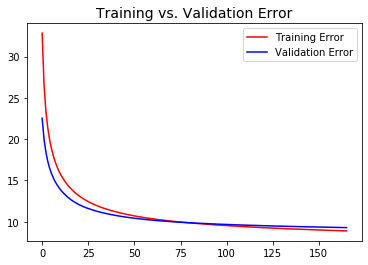

In [0]:

from matplotlib import pyplot

Train_draw=[]
Valid_draw=[]
for i in range(0,len(train_mse)):
  if i%1==0:
    Train_draw.append(train_mse[i])
    Valid_draw.append(validation_mse[i])

plt.title("Training vs. Validation Error", fontsize=14)
#plt.legend(loc="lower right")
plt.plot(Train_draw[1:], markersize=10, label="Training Error",color='red')
plt.plot(Valid_draw[1:], markersize=10, label="Validation Error",color='blue')
plt.legend(loc="upper right")
plt.savefig('Training vs Testing Error.png')
plt.show()
